# Análise não-linear de séries temporais
Este tipo de análise consiste em um conjunto de metodologias que começaram a ser desenvolvidas na década de 1990 com a finalidade de estudar sistemas complexos. Uma [boa revisão](https://aip.scitation.org/doi/pdf/10.1063/1.4917289?casa_token=J6ENq2j7UZYAAAAA:zHvGR93etcwS0jZPxq1Gu3sw1xPcVefi89Qh3lepPIFxUm6zkQcdnGPXPVbR3Rvo9qg_LFdtlMzQ) deste assunto nos informa que se trata de buscar caracterizar o sistema dinâmico por trás do fenômeno estudado, frequentemente, um sistema caótico deterministico.

In [34]:
import numpy as np
import scipy as sp
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from sklearn.metrics import mutual_info_score as MI
from scipy.integrate import odeint
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
%matplotlib inline 
plt.rcParams['figure.figsize'] = (15.0, 10.0)

## Reconstrução do espaço de estados
A reconstrução do espaço de estados do sistema dinâmico é a pedra fundamental desta metodologia. Para isso normalmente usamos Retratos de fase $m$-dimensionais atrasados da nossa série $y(t)$:

$$\overrightarrow{R}(t)=\left[y(t), y(t-\tau), y(t-2\tau),\ldots,y(t-(m-1)\tau)\right]$$

Vamos explorar esta reconstrução com uma série simulada a partir das equações de Rössler.

\begin{align}
\frac{dx}{dt}&=-y-z\\
\frac{dy}{dt}&=x+a y\\
\frac{dz}{dt}&=b + z  (x - c)
\end{align}

In [4]:
def rossler(Y,t,*pars):
    x,y,z = Y
    a,b,c = pars
    return [
        -y-z,
        x+(a*y),
        b+z*(x-c)
    ]

In [5]:
inits = [4,4,5]
a,b,c = 0.2, 0.2, 5.7
trange = range(20000)
res = odeint(rossler,inits,trange, args=(a,b,c))

<IPython.core.display.Javascript object>


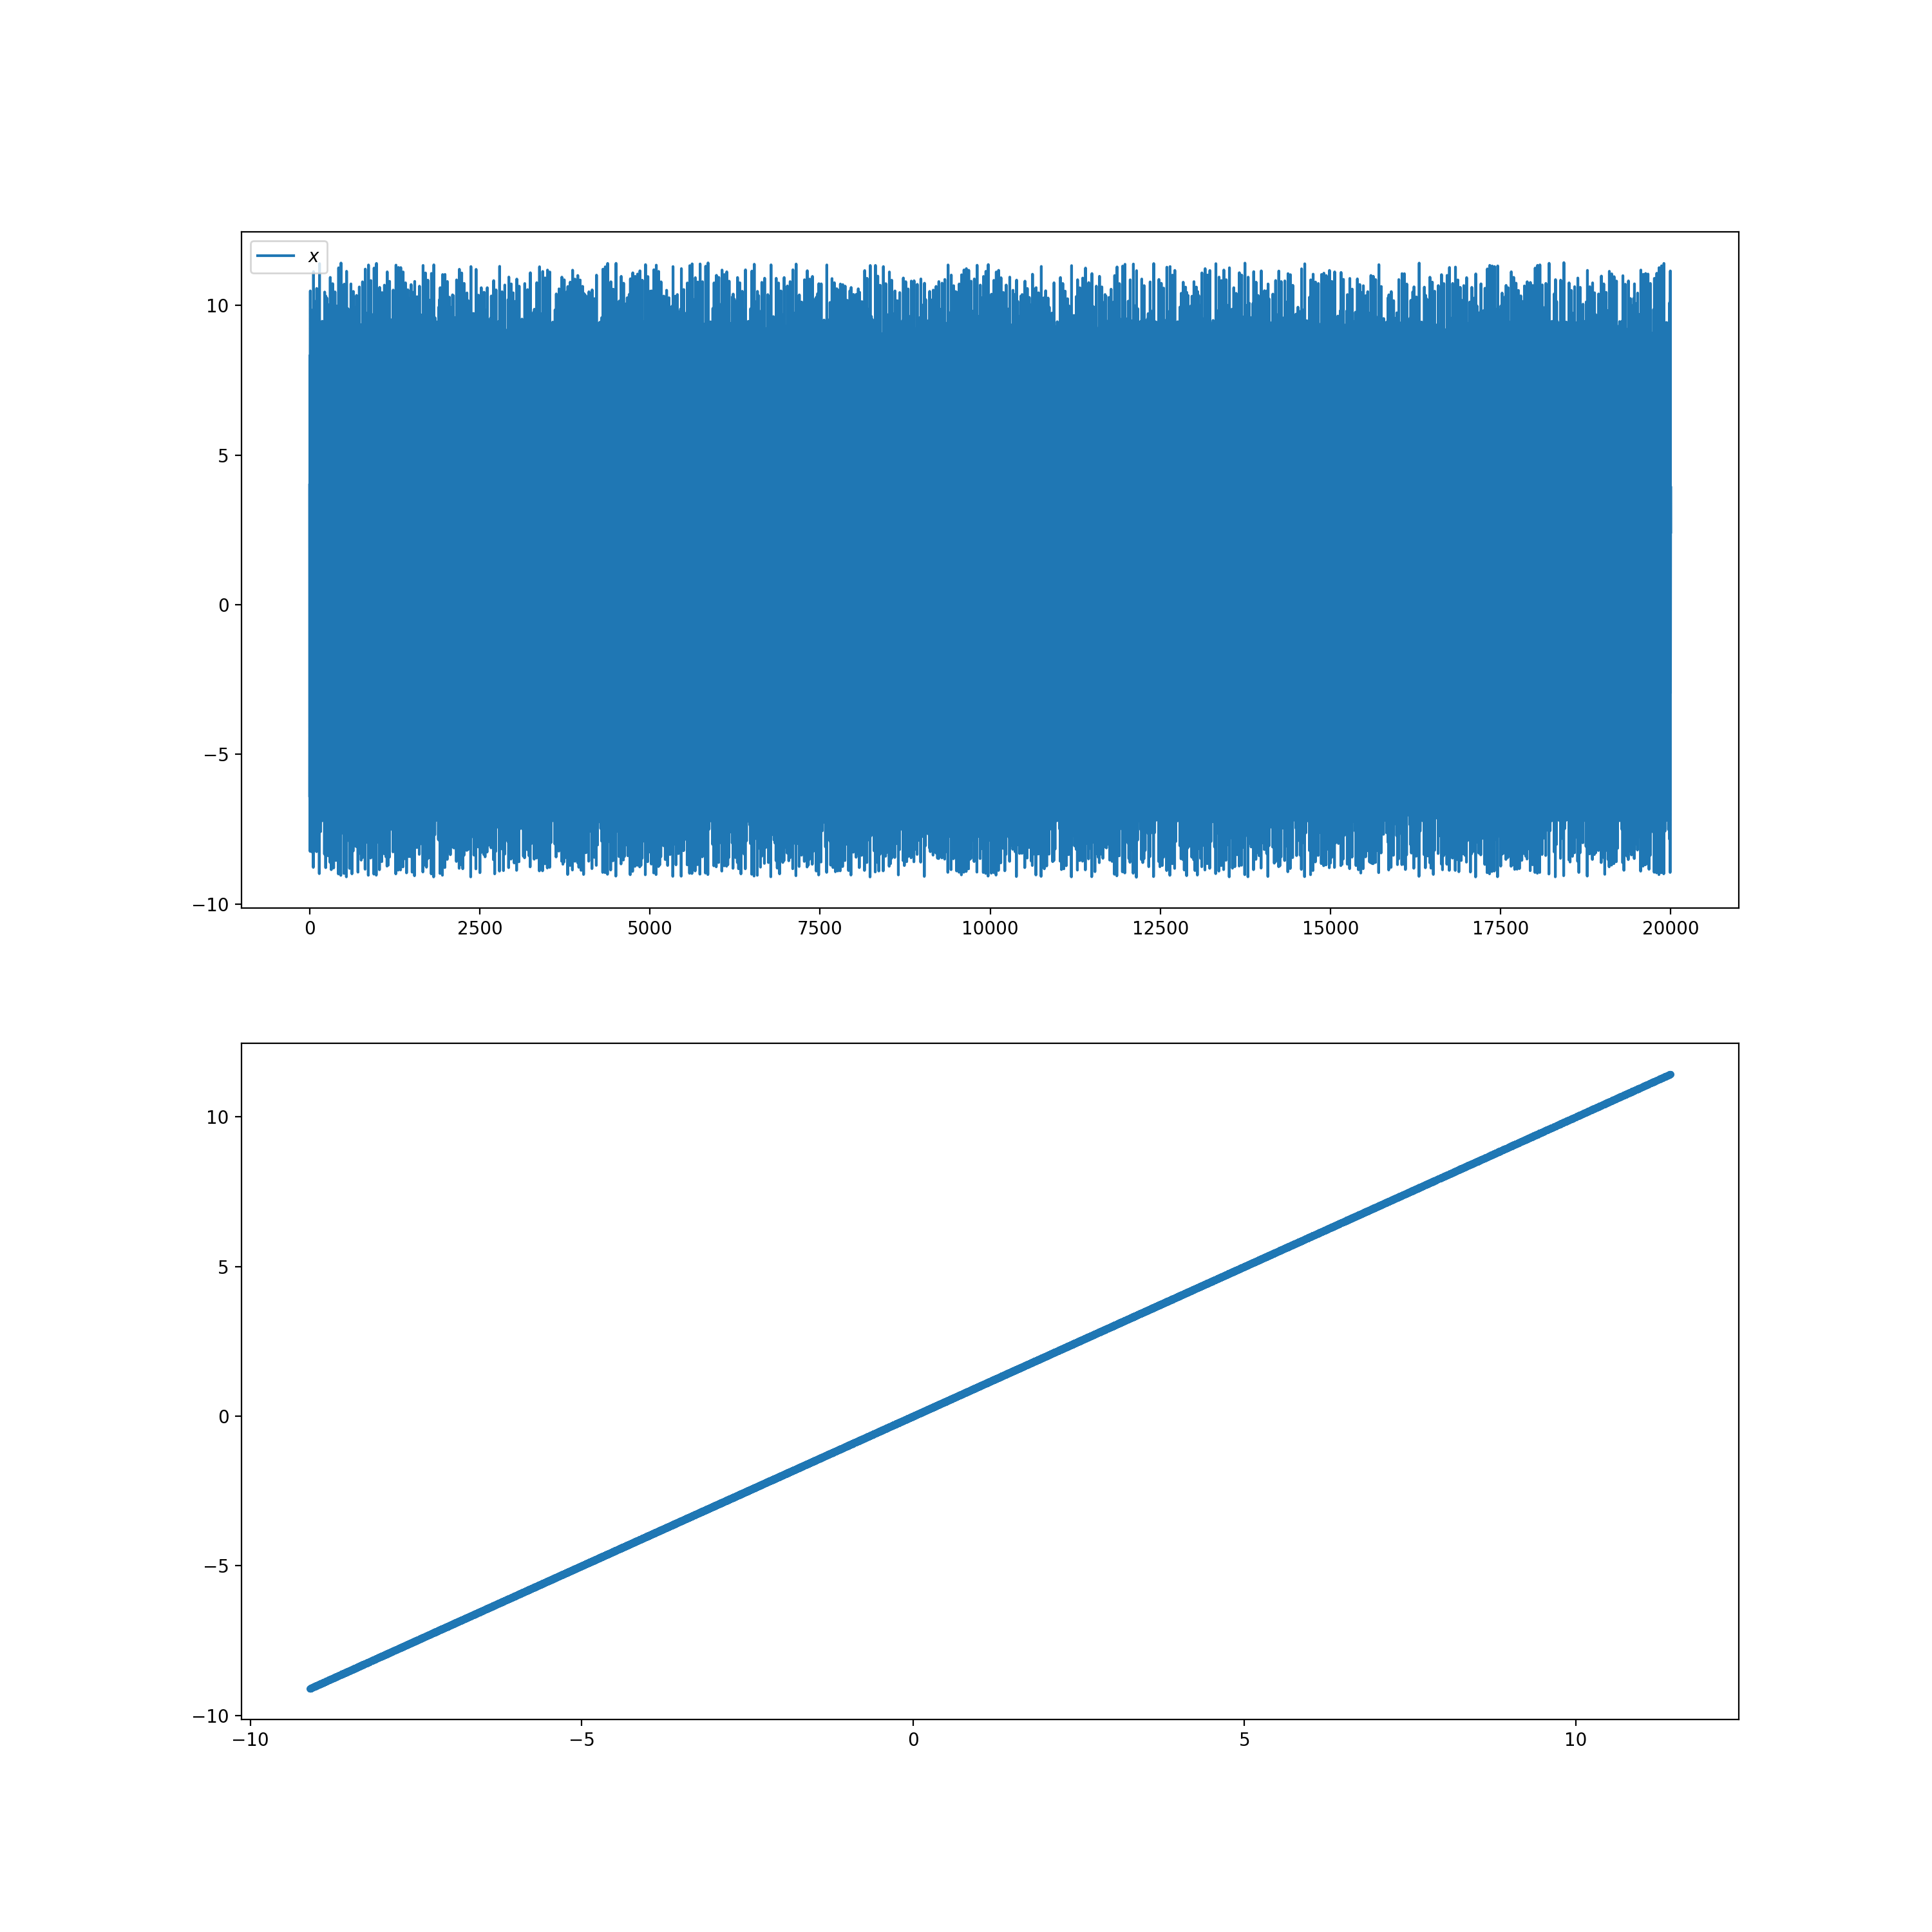

In [9]:
f,[ax1,ax2] = plt.subplots(2,1,figsize=(15,15))
ax1.plot(res[:,0], label='$x$');
ax1.legend()
ax2.plot(res[:,0],res[:,0], '.');

A series atrasadas com valores de $\tau$ pequenos, tendem a ser muito correlacionadas. Portanto a escolha de $\tau$ é importante. Abaixo temos uma figura interativa que nos permite visualizar o atrator do sistema em 3 dimensões para vários valores de $\tau$. Uma das maneiras mais comuns de se estima o melhor valor de $\tau$ é através da [informação mútua](https://en.wikipedia.org/wiki/Mutual_information) entre as séries, queremos encontrar o menor valor de tau, que minimiza a informação mútua.

Para simplicidade de cálculo podemos obter a informação mútual a partir da correlação
$$I=-\frac{1}{2}log(1-\rho^2)$$

Esta aproximação pressupões que ambas as séries têm distribuição Gaussiana.

In [12]:
@interact(tau=widgets.IntSlider(7,0,40,1))
def embed(tau):
    fig = plt.figure()
    ax=fig.gca(projection='3d')
    x,y,z = res[:-2*tau,0],res[tau:-tau,0], res[2*tau:,0]
    mi = MI(x,y)
    ax.plot(x,y,z, '.', alpha=0.5)
    ax.set_title(fr'$\tau={tau}$, Mutual information: {mi}')
    ax.set_xlabel(f'$x$')
    ax.set_ylabel(f'$x+{tau}$')
    ax.set_zlabel(f'$x+{2*tau}$')
    

interactive(children=(IntSlider(value=1, description='tau', max=40), Output()), _dom_classes=('widget-interact…

<IPython.core.display.Javascript object>


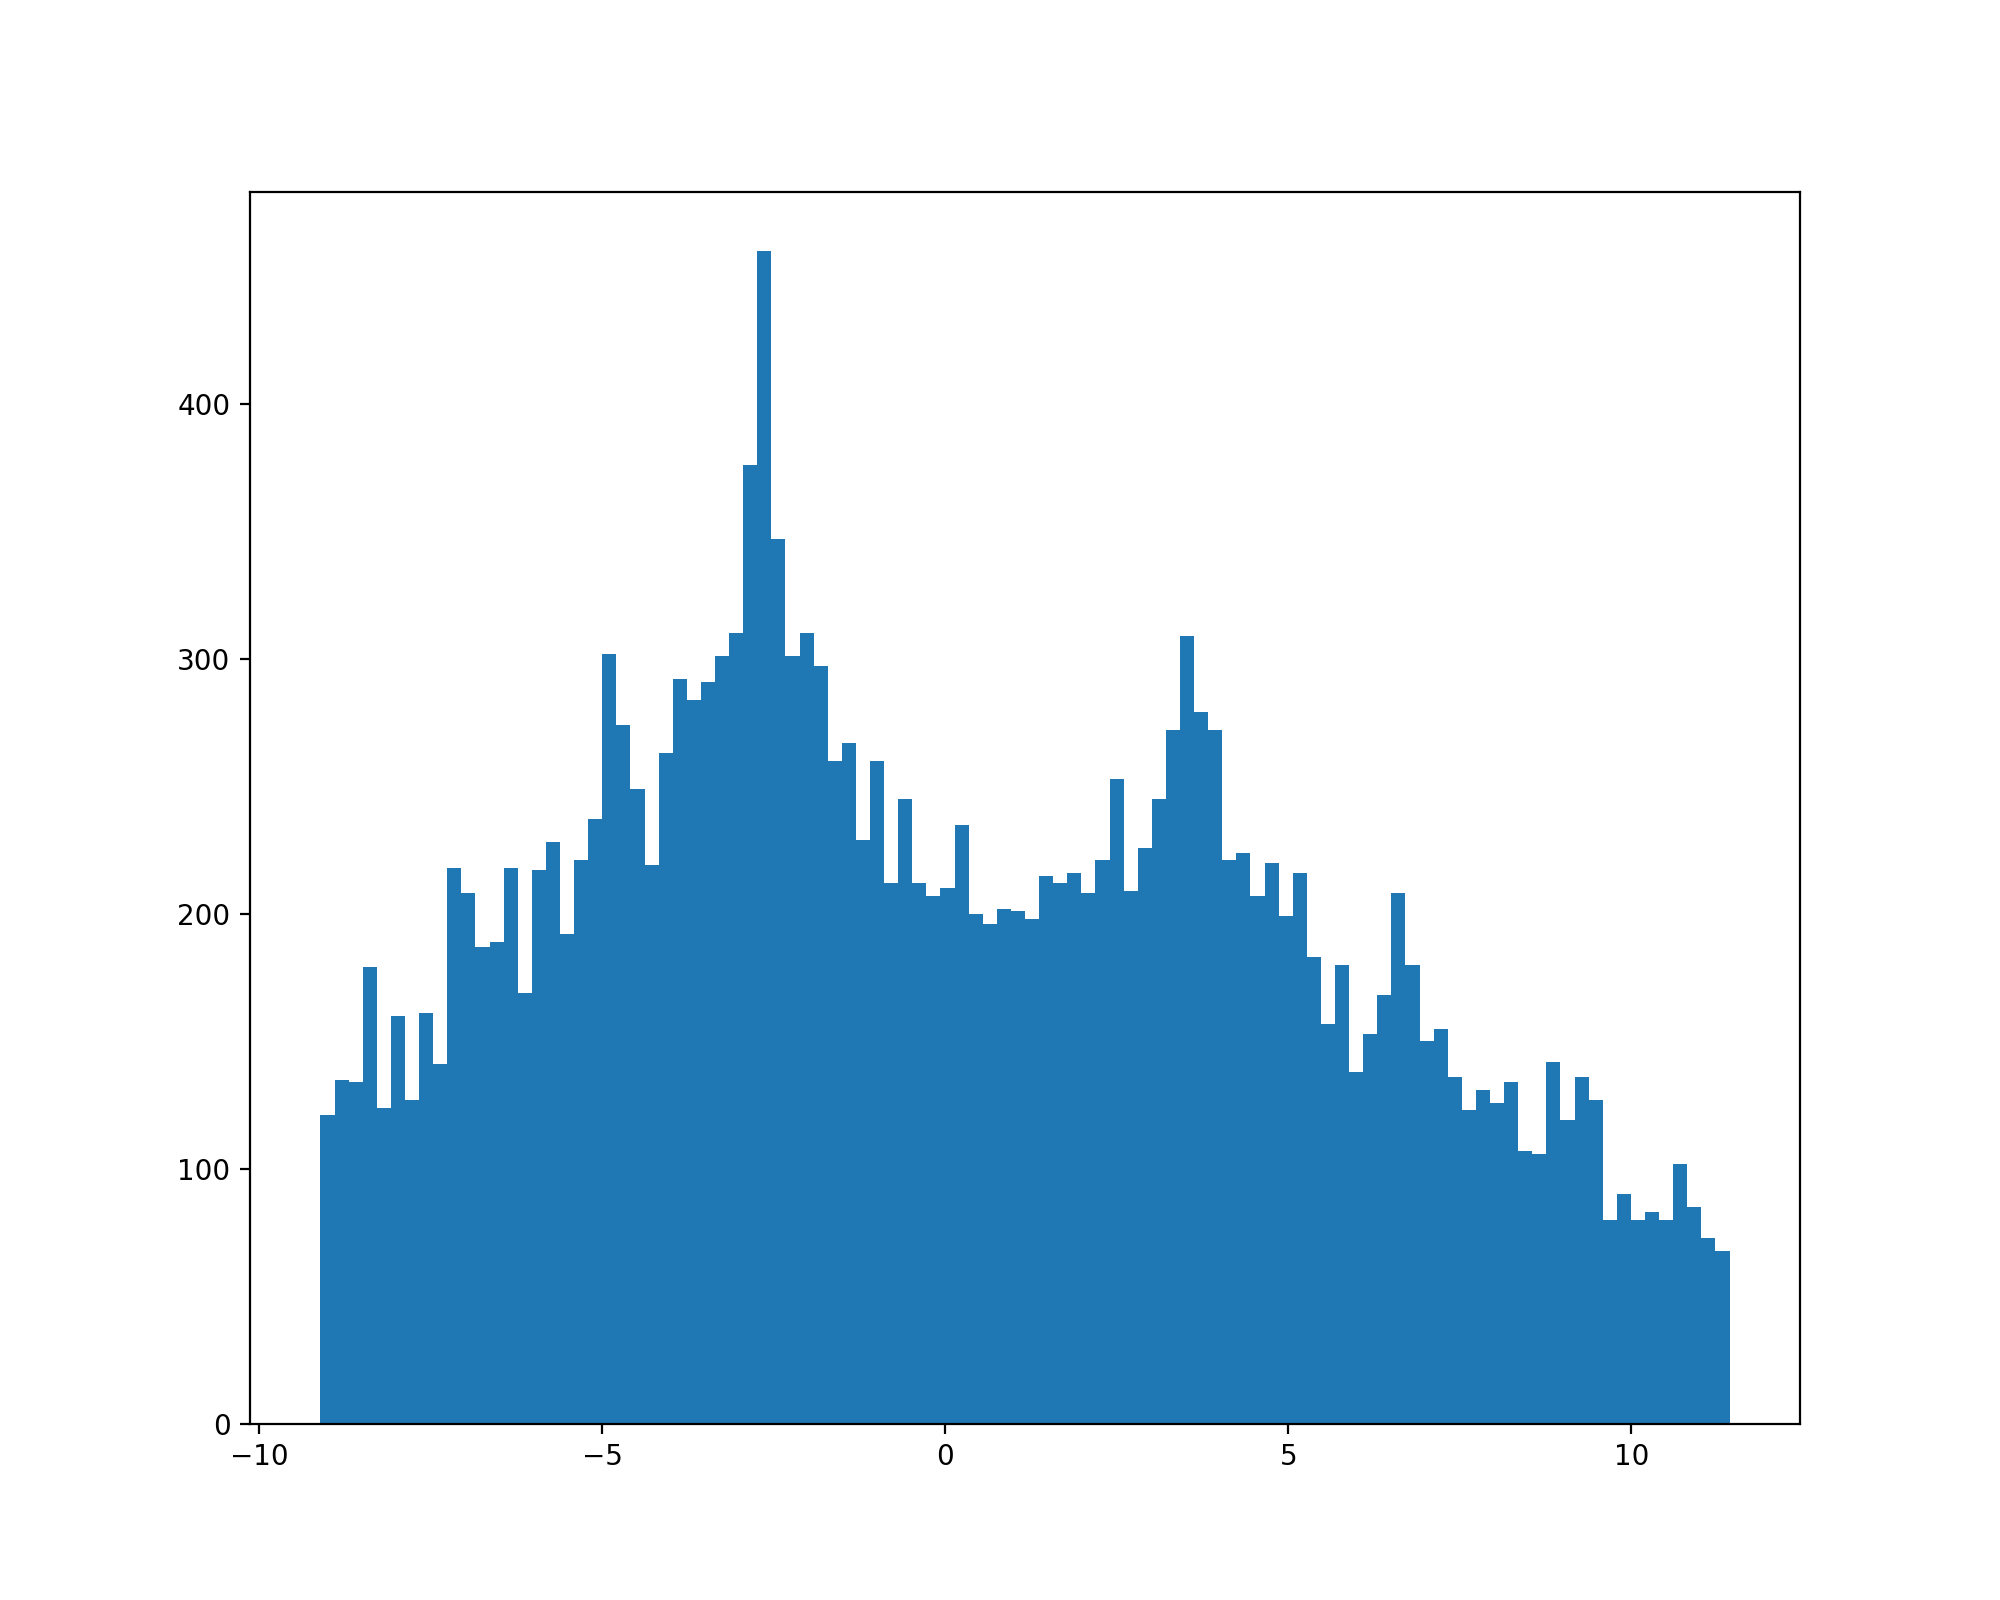

In [14]:
# Verificando a distibuição da série.
f,ax = plt.subplots(1,1,figsize=(10,8))
ax.hist(res[:,0],bins=100);

<IPython.core.display.Javascript object>


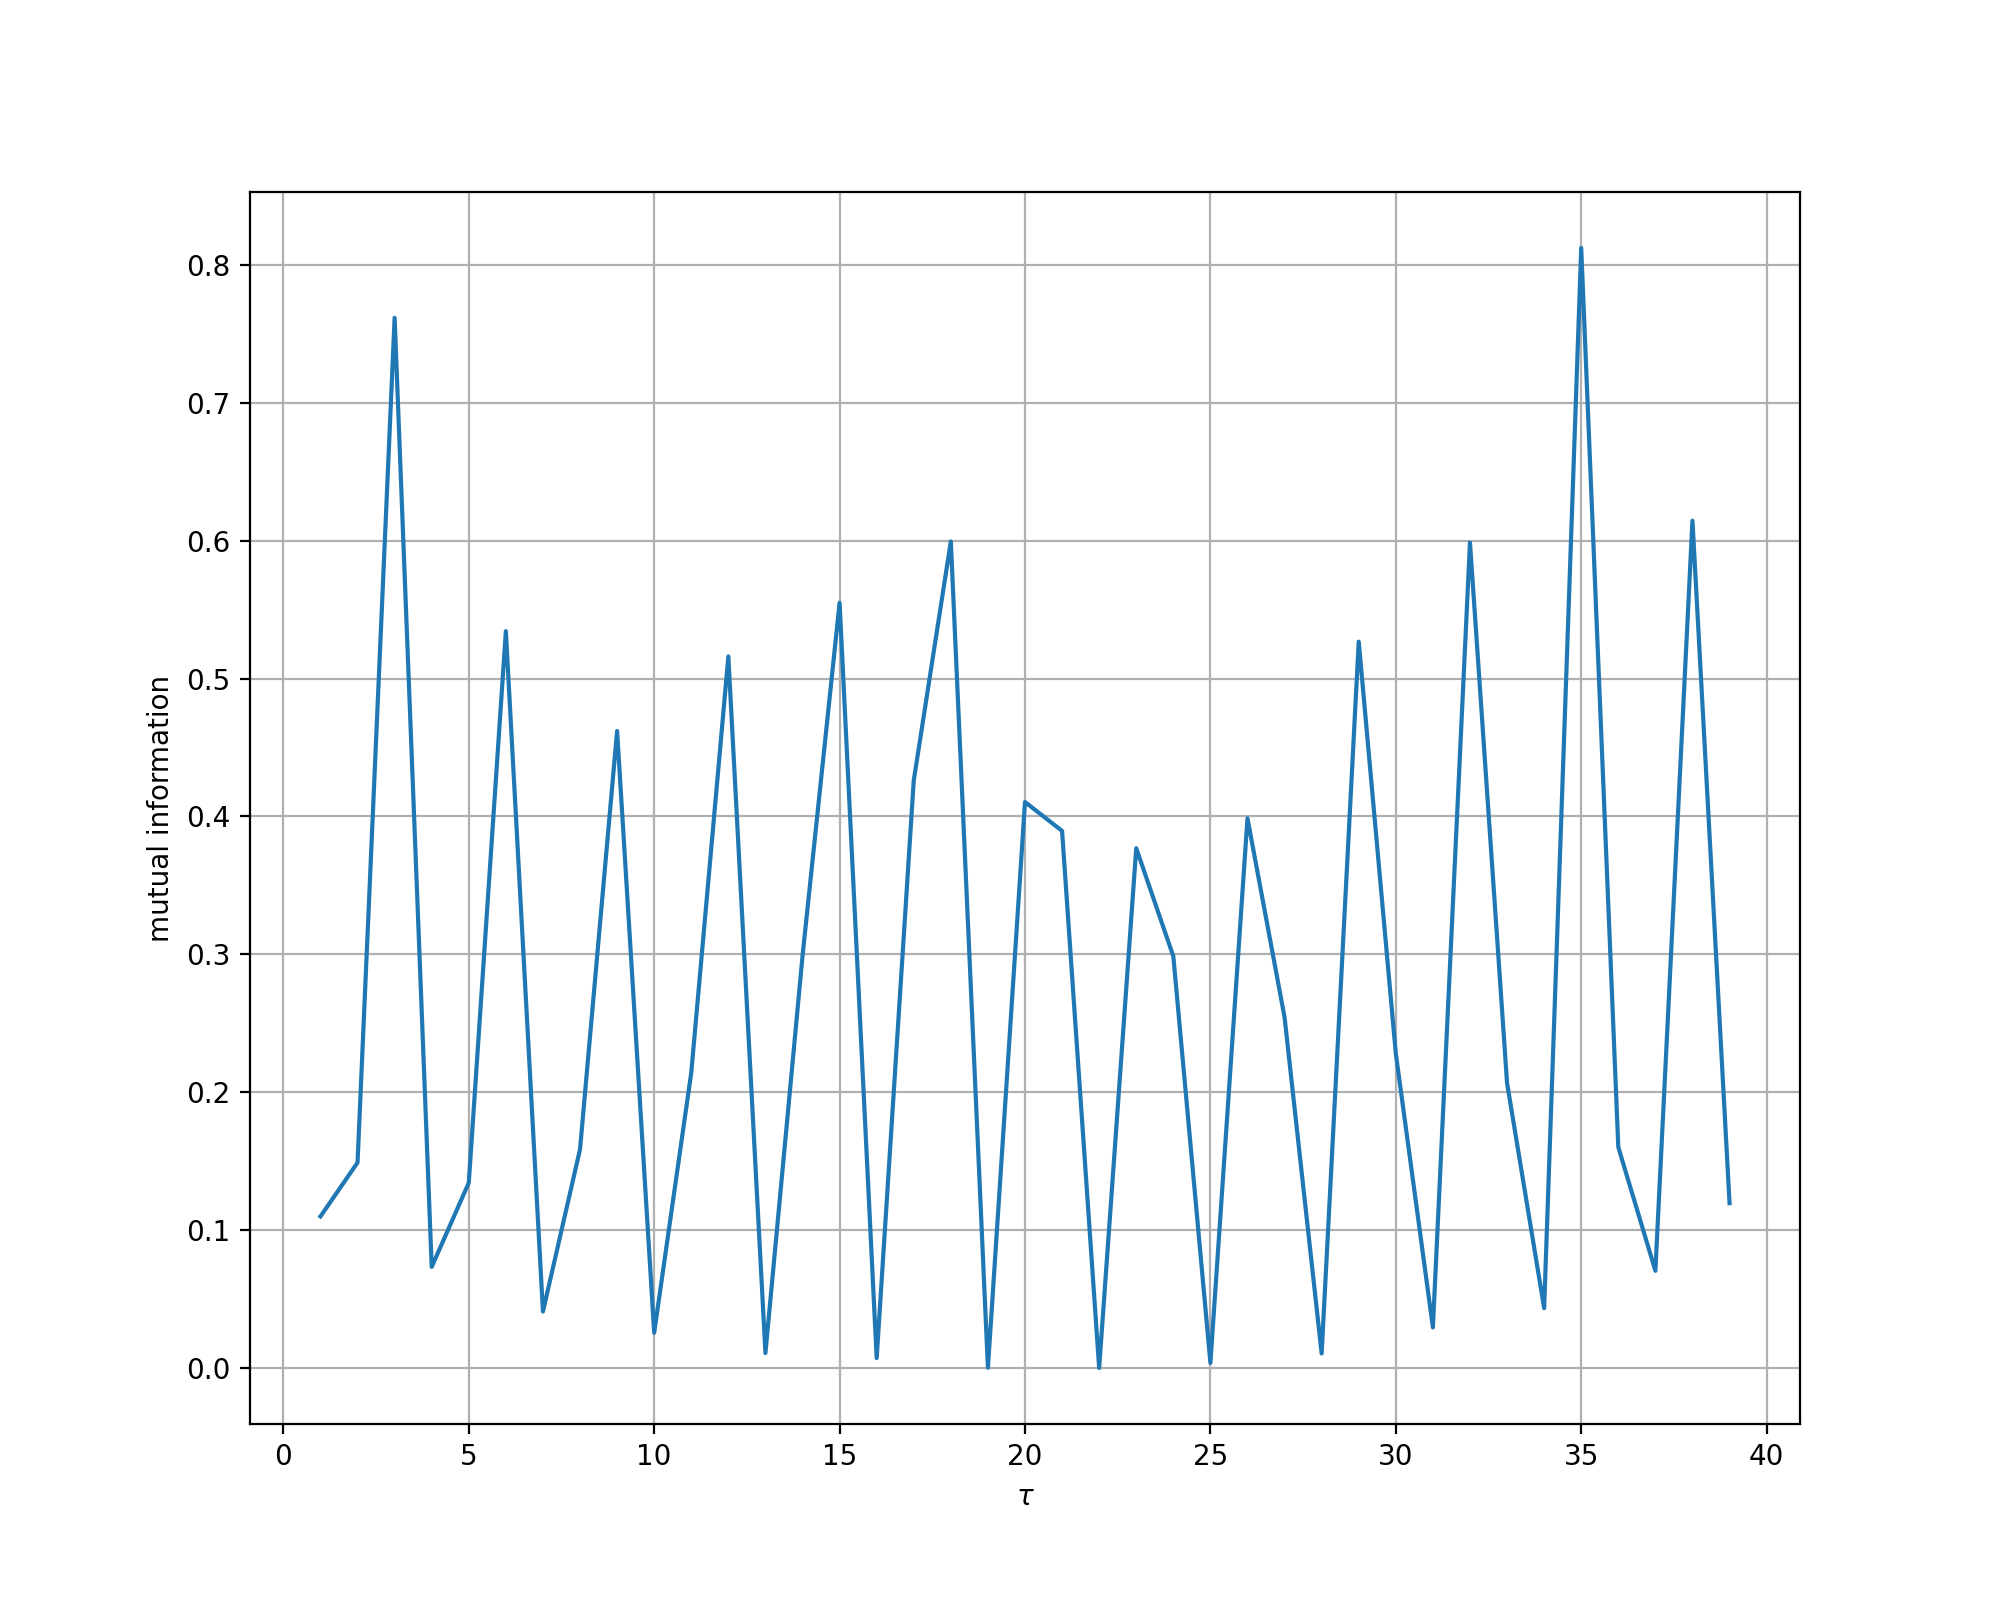

Text(0, 0.5, 'mutual information')

In [19]:
mis = []
for tau in range(1,40):
    mis.append(-0.5*np.log(1-pearsonr(res[:-tau,0],res[tau:,0])[0]**2))
#     mis.append(MI(res[:-tau,0],res[tau:,0]))
f,ax = plt.subplots(1,1,figsize=(10,8))
ax.plot(range(1,40),mis)
ax.grid()
ax.set_xlabel(r'$\tau$')
ax.set_ylabel(r'mutual information')

## Estimando $m$, a dimensão de embedding
Para esta parte vamos nos utilizar da biblioteca [nolds](https://github.com/CSchoel/nolds): Non-linear measures for Dynamical Systems. Nela temos a implementação do algoritmo  de Grassberger-Procaccia para cálculo da dimensão de correlação. Também vamos usar a biblioteca [Neurokit2](https://neurokit2.readthedocs.io) para estimação de dimensão de embedding.

In [30]:
import nolds
import neurokit2 as nk

In [31]:
nolds.corr_dim(res[:,0],4)

1.7979750803415464

{'delay': 4, 'dimension': 4, 'r': 0.6193779146523386}

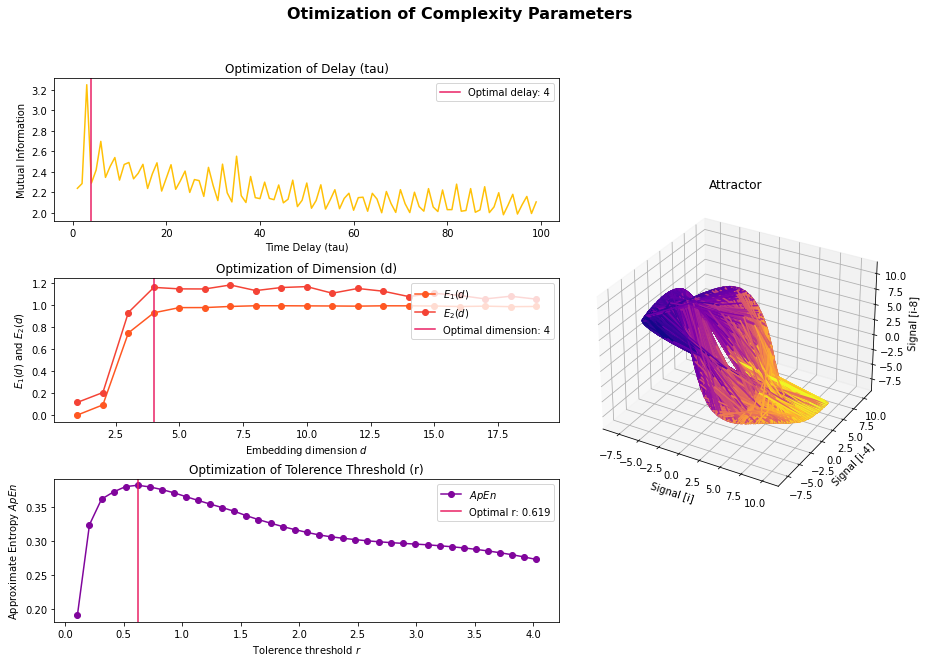

In [35]:
parameters = nk.complexity_optimize(res[:,0], show=True)
parameters

## Fazendo previsões a partir do sinal reconstruído.
Para testar a utilidade da reconstrução realizada, vamos utilizar uma regressão usando Kernel regression e também Lightgbm.

In [69]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error, mean_squared_error
from statsmodels.nonparametric.kernel_regression import KernelReg

In [40]:
data = pd.DataFrame(data={'ts':res[:,0]})
tau = 4
data['lag1'] = data.ts.shift(1*tau)
data['lag2'] = data.ts.shift(2*tau)
data['lag3'] = data.ts.shift(3*tau)
data['lag4'] = data.ts.shift(4*tau)
data

,ts,lag1,lag2,lag3,lag4
0,4.000000,NaN,NaN,NaN,NaN
1,-2.701291,NaN,NaN,NaN,NaN
2,-6.424261,NaN,NaN,NaN,NaN
3,-4.422475,NaN,NaN,NaN,NaN
4,2.517592,4.000000,NaN,NaN,NaN
...,...,...,...,...,...
19995,-2.921642,-4.679059,7.140714,-3.954312,-5.143011
19996,-1.382961,5.279095,2.531852,-5.201302,3.361338
19997,1.899994,11.153827,-4.979770,-1.427417,10.091506
19998,3.954745,-1.584968,-8.944661,4.618631,1.552838


Agora vamos remover as primeiras linhas que contém `NaN`s

In [42]:
data = data.dropna()
data

,ts,lag1,lag2,lag3,lag4
16,4.044545,0.925383,-8.239929,2.517592,4.000000
17,4.859027,-3.280940,-6.255662,8.328219,-2.701291
18,0.920742,-3.366459,2.529070,5.158565,-6.424261
19,-4.702702,-0.042813,10.486560,-2.988373,-4.422475
20,-6.760360,4.044545,0.925383,-8.239929,2.517592
...,...,...,...,...,...
19995,-2.921642,-4.679059,7.140714,-3.954312,-5.143011
19996,-1.382961,5.279095,2.531852,-5.201302,3.361338
19997,1.899994,11.153827,-4.979770,-1.427417,10.091506
19998,3.954745,-1.584968,-8.944661,4.618631,1.552838


### Kernel regression
Vamos usar a biblioteca statsmodels para ajustar a [regressão de kernel](https://www.statsmodels.org/devel/generated/statsmodels.nonparametric.kernel_regression.KernelReg.html#statsmodels.nonparametric.kernel_regression.KernelReg) nãp paramétrica. Para economizar tempo, vamos ajustar a regressão por Kernel utilizando apenas os primeiros 500 pontos. So we will use only the first 500 points to fit the regression model.

In [47]:
model = KernelReg(data.ts[:500], data[['lag1','lag2','lag3','lag4']][:500],var_type=['c','c','c','c'])

Agora vamos usar os 500 pontos seguintes para testar o poder preditivo do modelo.

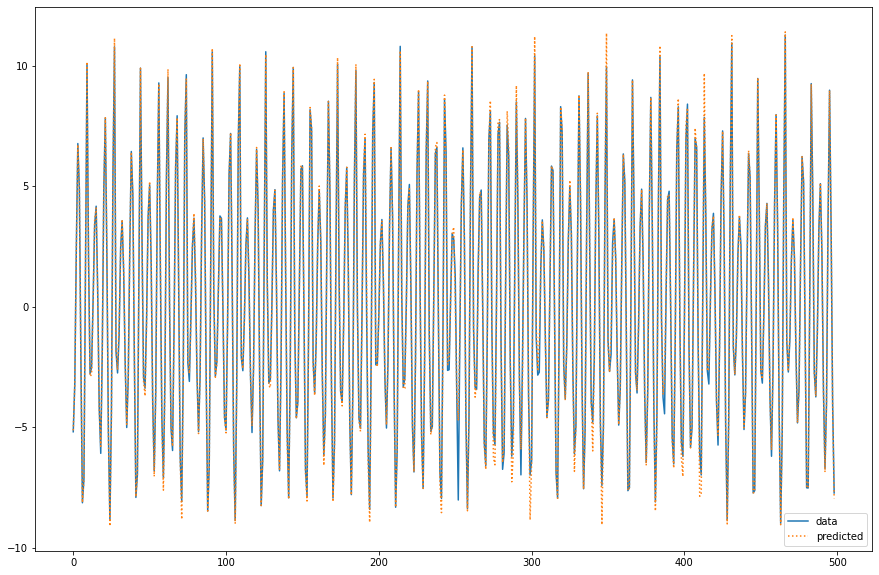

In [61]:
m,marg = model.fit(data_predict=data[['lag1','lag2','lag3','lag4']][501:1000])
plt.plot(m, label='data')
plt.plot(range(499),data.ts[501:1000],':',label='predicted')
plt.legend();

In [81]:
model.r_squared()

0.9992286285266908

### LightGBM regression

In [72]:
train_size = 1000
dftrain = data[['lag1','lag2','lag3','lag4']][:train_size]
dftest = data[['lag1','lag2','lag3','lag4']][train_size:train_size+500]
Y = data.ts[:train_size]

In [63]:
X_train, X_test, y_train, y_test = train_test_split( dftrain, Y, test_size=0.2, random_state=42)

In [64]:
hyper_params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': ['l2', 'auc'],
    'learning_rate': 0.005,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.7,
    'bagging_freq': 10,
    'verbose': 0,
    "max_depth": 8,
    "num_leaves": 128,  
    "max_bin": 512,
    "num_iterations": 100000,
    "n_estimators": 1000
}

In [65]:
gbm = lgb.LGBMRegressor(**hyper_params)


In [66]:
gbm.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric='l1',
        early_stopping_rounds=1000)

/usr/local/lib/python3.8/dist-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000083 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warn

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[130]	valid_0's l1: 2.29525	valid_0's l2: 7.98172	valid_0's auc: 0.982893
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[131]	valid_0's l1: 2.28594	valid_0's l2: 7.91776	valid_0's auc: 0.982793
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[132]	valid_0's l1: 2.27666	valid_0's l2: 7.85447	valid_0's auc: 0.982893
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[133]	valid_0's l1: 2.26744	valid_0's l2: 7.79185	valid_0's auc: 0.982993
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[134]	valid_0's l1: 2.25834	valid_0's l2: 7.73026	valid_0's auc: 0.983093
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[135]	valid_0's l1: 2.24921	valid_0's l2: 7.66894	valid_0's auc: 0.983193
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[136]	valid_0's l1: 2.23986	val

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[214]	valid_0's l1: 1.67854	valid_0's l2: 4.37148	valid_0's auc: 0.984294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[215]	valid_0's l1: 1.67268	valid_0's l2: 4.34235	valid_0's auc: 0.984494
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[216]	valid_0's l1: 1.66684	valid_0's l2: 4.31351	valid_0's auc: 0.984394
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[217]	valid_0's l1: 1.66103	valid_0's l2: 4.28497	valid_0's auc: 0.984394
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[218]	valid_0's l1: 1.65525	valid_0's l2: 4.25671	valid_0's auc: 0.984494
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[219]	valid_0's l1: 1.6495	valid_0's l2: 4.22874	valid_0's auc: 0.984494
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[220]	valid_0's l1: 1.64385	vali

[421]	valid_0's l1: 0.998004	valid_0's l2: 1.58079	valid_0's auc: 0.988595
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[422]	valid_0's l1: 0.996193	valid_0's l2: 1.57514	valid_0's auc: 0.988595
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[423]	valid_0's l1: 0.994359	valid_0's l2: 1.56952	valid_0's auc: 0.988495
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[424]	valid_0's l1: 0.992565	valid_0's l2: 1.56398	valid_0's auc: 0.988695
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[425]	valid_0's l1: 0.99075	valid_0's l2: 1.55847	valid_0's auc: 0.988695
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[426]	valid_0's l1: 0.988944	valid_0's l2: 1.55303	valid_0's auc: 0.988595
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[427]	valid_0's l1: 0.987188	valid_0's l2: 1.54764	valid_0's auc: 0.988595
[LightGBM] [Warning] No fu

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[601]	valid_0's l1: 0.813468	valid_0's l2: 1.06574	valid_0's auc: 0.990096
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[602]	valid_0's l1: 0.812732	valid_0's l2: 1.06428	valid_0's auc: 0.990096
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[603]	valid_0's l1: 0.811925	valid_0's l2: 1.06278	valid_0's auc: 0.990096
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[604]	valid_0's l1: 0.811285	valid_0's l2: 1.06149	valid_0's auc: 0.990196
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[605]	valid_0's l1: 0.810484	valid_0's l2: 1.06002	valid_0's auc: 0.990196
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[606]	valid_0's l1: 0.80985	valid_0's l2: 1.05876	valid_0's auc: 0.990096
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[607]	valid_0's l1: 0.8091

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[827]	valid_0's l1: 0.696799	valid_0's l2: 0.842973	valid_0's auc: 0.991797
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[828]	valid_0's l1: 0.696411	valid_0's l2: 0.842271	valid_0's auc: 0.991797
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[829]	valid_0's l1: 0.696026	valid_0's l2: 0.841576	valid_0's auc: 0.991797
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[830]	valid_0's l1: 0.695642	valid_0's l2: 0.840889	valid_0's auc: 0.991797
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[831]	valid_0's l1: 0.695351	valid_0's l2: 0.840217	valid_0's auc: 0.991897
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[832]	valid_0's l1: 0.695035	valid_0's l2: 0.839526	valid_0's auc: 0.991897
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[833]	valid_0's l1:

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1032]	valid_0's l1: 0.650946	valid_0's l2: 0.761336	valid_0's auc: 0.993497
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1033]	valid_0's l1: 0.650609	valid_0's l2: 0.760878	valid_0's auc: 0.993497
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1034]	valid_0's l1: 0.650294	valid_0's l2: 0.76046	valid_0's auc: 0.993497
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1035]	valid_0's l1: 0.649997	valid_0's l2: 0.760068	valid_0's auc: 0.993497
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1036]	valid_0's l1: 0.649664	valid_0's l2: 0.759623	valid_0's auc: 0.993497
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1037]	valid_0's l1: 0.649526	valid_0's l2: 0.759415	valid_0's auc: 0.993497
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1038]	valid_0

[1193]	valid_0's l1: 0.619978	valid_0's l2: 0.712081	valid_0's auc: 0.994398
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1194]	valid_0's l1: 0.619638	valid_0's l2: 0.711675	valid_0's auc: 0.994398
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1195]	valid_0's l1: 0.619299	valid_0's l2: 0.711275	valid_0's auc: 0.994298
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1196]	valid_0's l1: 0.618974	valid_0's l2: 0.710911	valid_0's auc: 0.994198
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1197]	valid_0's l1: 0.618624	valid_0's l2: 0.710508	valid_0's auc: 0.994198
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1198]	valid_0's l1: 0.618261	valid_0's l2: 0.710103	valid_0's auc: 0.994198
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1199]	valid_0's l1: 0.617913	valid_0's l2: 0.709712	valid_0's auc: 0.994198
[LightGBM] 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1330]	valid_0's l1: 0.603154	valid_0's l2: 0.688063	valid_0's auc: 0.994398
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1331]	valid_0's l1: 0.603174	valid_0's l2: 0.688038	valid_0's auc: 0.994398
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1332]	valid_0's l1: 0.603144	valid_0's l2: 0.687918	valid_0's auc: 0.994398
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1333]	valid_0's l1: 0.603114	valid_0's l2: 0.6878	valid_0's auc: 0.994398
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1334]	valid_0's l1: 0.603129	valid_0's l2: 0.687797	valid_0's auc: 0.994398
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1335]	valid_0's l1: 0.603099	valid_0's l2: 0.687682	valid_0's auc: 0.994398
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1336]	valid_0'

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1558]	valid_0's l1: 0.585499	valid_0's l2: 0.650921	valid_0's auc: 0.994498
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1559]	valid_0's l1: 0.58541	valid_0's l2: 0.650786	valid_0's auc: 0.994498
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1560]	valid_0's l1: 0.58531	valid_0's l2: 0.650618	valid_0's auc: 0.994398
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1561]	valid_0's l1: 0.585148	valid_0's l2: 0.650216	valid_0's auc: 0.994398
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1562]	valid_0's l1: 0.584986	valid_0's l2: 0.649817	valid_0's auc: 0.994398
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1563]	valid_0's l1: 0.584826	valid_0's l2: 0.649422	valid_0's auc: 0.994398
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1564]	valid_0'

[1662]	valid_0's l1: 0.578294	valid_0's l2: 0.638127	valid_0's auc: 0.994698
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1663]	valid_0's l1: 0.578236	valid_0's l2: 0.638089	valid_0's auc: 0.994698
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1664]	valid_0's l1: 0.578145	valid_0's l2: 0.638049	valid_0's auc: 0.994698
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1665]	valid_0's l1: 0.578088	valid_0's l2: 0.638014	valid_0's auc: 0.994698
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1666]	valid_0's l1: 0.577997	valid_0's l2: 0.637977	valid_0's auc: 0.994698
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1667]	valid_0's l1: 0.577941	valid_0's l2: 0.637944	valid_0's auc: 0.994698
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1668]	valid_0's l1: 0.577858	valid_0's l2: 0.637909	valid_0's auc: 0.994698
[LightGBM] 

[1958]	valid_0's l1: 0.56154	valid_0's l2: 0.60883	valid_0's auc: 0.995098
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1959]	valid_0's l1: 0.561537	valid_0's l2: 0.608808	valid_0's auc: 0.995098
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1960]	valid_0's l1: 0.561485	valid_0's l2: 0.60876	valid_0's auc: 0.995098
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1961]	valid_0's l1: 0.561321	valid_0's l2: 0.608453	valid_0's auc: 0.995098
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1962]	valid_0's l1: 0.561166	valid_0's l2: 0.608107	valid_0's auc: 0.995098
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1963]	valid_0's l1: 0.561027	valid_0's l2: 0.607808	valid_0's auc: 0.995098
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1964]	valid_0's l1: 0.560874	valid_0's l2: 0.607468	valid_0's auc: 0.995098
[LightGBM] [Wa

[2137]	valid_0's l1: 0.551351	valid_0's l2: 0.591149	valid_0's auc: 0.995198
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2138]	valid_0's l1: 0.551287	valid_0's l2: 0.591085	valid_0's auc: 0.995198
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2139]	valid_0's l1: 0.551251	valid_0's l2: 0.590925	valid_0's auc: 0.995198
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2140]	valid_0's l1: 0.551193	valid_0's l2: 0.590908	valid_0's auc: 0.995198
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2141]	valid_0's l1: 0.551139	valid_0's l2: 0.590788	valid_0's auc: 0.995198
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2142]	valid_0's l1: 0.551103	valid_0's l2: 0.590689	valid_0's auc: 0.995198
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2143]	valid_0's l1: 0.551049	valid_0's l2: 0.590571	valid_0's auc: 0.995198
[LightGBM] 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2205]	valid_0's l1: 0.548359	valid_0's l2: 0.585584	valid_0's auc: 0.995298
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2206]	valid_0's l1: 0.548311	valid_0's l2: 0.58548	valid_0's auc: 0.995298
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2207]	valid_0's l1: 0.548276	valid_0's l2: 0.585415	valid_0's auc: 0.995198
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2208]	valid_0's l1: 0.548229	valid_0's l2: 0.585313	valid_0's auc: 0.995198
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2209]	valid_0's l1: 0.548183	valid_0's l2: 0.585228	valid_0's auc: 0.995198
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2210]	valid_0's l1: 0.548136	valid_0's l2: 0.585127	valid_0's auc: 0.995198
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2211]	valid_0

[2421]	valid_0's l1: 0.543942	valid_0's l2: 0.576937	valid_0's auc: 0.995298
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2422]	valid_0's l1: 0.543927	valid_0's l2: 0.576884	valid_0's auc: 0.995298
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2423]	valid_0's l1: 0.543913	valid_0's l2: 0.576832	valid_0's auc: 0.995298
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2424]	valid_0's l1: 0.543899	valid_0's l2: 0.576801	valid_0's auc: 0.995298
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2425]	valid_0's l1: 0.543885	valid_0's l2: 0.576749	valid_0's auc: 0.995298
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2426]	valid_0's l1: 0.543871	valid_0's l2: 0.576699	valid_0's auc: 0.995298
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2427]	valid_0's l1: 0.543879	valid_0's l2: 0.576657	valid_0's auc: 0.995298
[LightGBM] 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2570]	valid_0's l1: 0.540127	valid_0's l2: 0.569471	valid_0's auc: 0.995398
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2571]	valid_0's l1: 0.540092	valid_0's l2: 0.569406	valid_0's auc: 0.995398
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2572]	valid_0's l1: 0.540058	valid_0's l2: 0.569342	valid_0's auc: 0.995398
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2573]	valid_0's l1: 0.540023	valid_0's l2: 0.569279	valid_0's auc: 0.995398
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2574]	valid_0's l1: 0.539932	valid_0's l2: 0.569097	valid_0's auc: 0.995398
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2575]	valid_0's l1: 0.539842	valid_0's l2: 0.568918	valid_0's auc: 0.995398
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2576]	valid_

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2805]	valid_0's l1: 0.534786	valid_0's l2: 0.561279	valid_0's auc: 0.995698
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2806]	valid_0's l1: 0.534791	valid_0's l2: 0.561273	valid_0's auc: 0.995698
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2807]	valid_0's l1: 0.534793	valid_0's l2: 0.56127	valid_0's auc: 0.995698
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2808]	valid_0's l1: 0.534799	valid_0's l2: 0.561265	valid_0's auc: 0.995698
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2809]	valid_0's l1: 0.534802	valid_0's l2: 0.561262	valid_0's auc: 0.995698
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2810]	valid_0's l1: 0.534809	valid_0's l2: 0.561258	valid_0's auc: 0.995698
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2811]	valid_0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2976]	valid_0's l1: 0.530352	valid_0's l2: 0.550974	valid_0's auc: 0.995798
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2977]	valid_0's l1: 0.530289	valid_0's l2: 0.551025	valid_0's auc: 0.995798
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2978]	valid_0's l1: 0.530245	valid_0's l2: 0.551086	valid_0's auc: 0.995798
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2979]	valid_0's l1: 0.530174	valid_0's l2: 0.55111	valid_0's auc: 0.995798
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2980]	valid_0's l1: 0.530106	valid_0's l2: 0.551084	valid_0's auc: 0.995798
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2981]	valid_0's l1: 0.530064	valid_0's l2: 0.550978	valid_0's auc: 0.995798
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2982]	valid_0

[3126]	valid_0's l1: 0.528852	valid_0's l2: 0.549872	valid_0's auc: 0.995798
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3127]	valid_0's l1: 0.528821	valid_0's l2: 0.549752	valid_0's auc: 0.995798
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3128]	valid_0's l1: 0.52879	valid_0's l2: 0.549635	valid_0's auc: 0.995798
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3129]	valid_0's l1: 0.528742	valid_0's l2: 0.549449	valid_0's auc: 0.995798
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3130]	valid_0's l1: 0.528711	valid_0's l2: 0.549332	valid_0's auc: 0.995798
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3131]	valid_0's l1: 0.528702	valid_0's l2: 0.549305	valid_0's auc: 0.995798
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3132]	valid_0's l1: 0.528693	valid_0's l2: 0.549279	valid_0's auc: 0.995798
[LightGBM] [

[3306]	valid_0's l1: 0.523555	valid_0's l2: 0.542261	valid_0's auc: 0.995798
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3307]	valid_0's l1: 0.523577	valid_0's l2: 0.542345	valid_0's auc: 0.995798
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3308]	valid_0's l1: 0.52359	valid_0's l2: 0.542421	valid_0's auc: 0.995798
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3309]	valid_0's l1: 0.523609	valid_0's l2: 0.542499	valid_0's auc: 0.995798
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3310]	valid_0's l1: 0.523637	valid_0's l2: 0.542583	valid_0's auc: 0.995798
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3311]	valid_0's l1: 0.523611	valid_0's l2: 0.542515	valid_0's auc: 0.995798
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3312]	valid_0's l1: 0.523596	valid_0's l2: 0.542468	valid_0's auc: 0.995798
[LightGBM] [

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3506]	valid_0's l1: 0.519882	valid_0's l2: 0.535813	valid_0's auc: 0.996098
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3507]	valid_0's l1: 0.519856	valid_0's l2: 0.535724	valid_0's auc: 0.996098
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3508]	valid_0's l1: 0.51982	valid_0's l2: 0.535649	valid_0's auc: 0.996098
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3509]	valid_0's l1: 0.519794	valid_0's l2: 0.535561	valid_0's auc: 0.996098
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3510]	valid_0's l1: 0.519769	valid_0's l2: 0.535473	valid_0's auc: 0.996098
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3511]	valid_0's l1: 0.519768	valid_0's l2: 0.535455	valid_0's auc: 0.996098
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3512]	valid_0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3751]	valid_0's l1: 0.518472	valid_0's l2: 0.535491	valid_0's auc: 0.996499
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3752]	valid_0's l1: 0.51852	valid_0's l2: 0.535589	valid_0's auc: 0.996499
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3753]	valid_0's l1: 0.518569	valid_0's l2: 0.535687	valid_0's auc: 0.996499
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3754]	valid_0's l1: 0.518617	valid_0's l2: 0.535785	valid_0's auc: 0.996499
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3755]	valid_0's l1: 0.51867	valid_0's l2: 0.535887	valid_0's auc: 0.996499
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3756]	valid_0's l1: 0.518718	valid_0's l2: 0.535985	valid_0's auc: 0.996499
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3757]	valid_0'

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3975]	valid_0's l1: 0.516205	valid_0's l2: 0.531724	valid_0's auc: 0.996599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3976]	valid_0's l1: 0.51617	valid_0's l2: 0.531661	valid_0's auc: 0.996599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3977]	valid_0's l1: 0.516134	valid_0's l2: 0.531599	valid_0's auc: 0.996599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3978]	valid_0's l1: 0.516099	valid_0's l2: 0.531537	valid_0's auc: 0.996599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3979]	valid_0's l1: 0.516065	valid_0's l2: 0.531475	valid_0's auc: 0.996599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3980]	valid_0's l1: 0.51603	valid_0's l2: 0.531415	valid_0's auc: 0.996599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3981]	valid_0'

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4114]	valid_0's l1: 0.514664	valid_0's l2: 0.528116	valid_0's auc: 0.996799
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4115]	valid_0's l1: 0.514621	valid_0's l2: 0.528077	valid_0's auc: 0.996799
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4116]	valid_0's l1: 0.514579	valid_0's l2: 0.528033	valid_0's auc: 0.996799
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4117]	valid_0's l1: 0.514516	valid_0's l2: 0.52798	valid_0's auc: 0.996799
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4118]	valid_0's l1: 0.514493	valid_0's l2: 0.527964	valid_0's auc: 0.996799
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4119]	valid_0's l1: 0.514448	valid_0's l2: 0.527922	valid_0's auc: 0.996799
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4120]	valid_0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4282]	valid_0's l1: 0.510569	valid_0's l2: 0.521672	valid_0's auc: 0.996699
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4283]	valid_0's l1: 0.510576	valid_0's l2: 0.521757	valid_0's auc: 0.996799
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4284]	valid_0's l1: 0.510586	valid_0's l2: 0.521842	valid_0's auc: 0.996799
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4285]	valid_0's l1: 0.510593	valid_0's l2: 0.521926	valid_0's auc: 0.996799
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4286]	valid_0's l1: 0.510602	valid_0's l2: 0.522011	valid_0's auc: 0.996799
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4287]	valid_0's l1: 0.51061	valid_0's l2: 0.522095	valid_0's auc: 0.996799
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4288]	valid_0

[4470]	valid_0's l1: 0.508307	valid_0's l2: 0.5189	valid_0's auc: 0.997099
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4471]	valid_0's l1: 0.508222	valid_0's l2: 0.518764	valid_0's auc: 0.997099
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4472]	valid_0's l1: 0.508137	valid_0's l2: 0.518628	valid_0's auc: 0.997099
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4473]	valid_0's l1: 0.508051	valid_0's l2: 0.518495	valid_0's auc: 0.997099
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4474]	valid_0's l1: 0.507999	valid_0's l2: 0.518429	valid_0's auc: 0.997099
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4475]	valid_0's l1: 0.507915	valid_0's l2: 0.518297	valid_0's auc: 0.997099
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4476]	valid_0's l1: 0.507866	valid_0's l2: 0.518233	valid_0's auc: 0.997099
[LightGBM] [W

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4586]	valid_0's l1: 0.50609	valid_0's l2: 0.515208	valid_0's auc: 0.996999
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4587]	valid_0's l1: 0.506087	valid_0's l2: 0.515192	valid_0's auc: 0.996999
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4588]	valid_0's l1: 0.506075	valid_0's l2: 0.51518	valid_0's auc: 0.996999
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4589]	valid_0's l1: 0.506073	valid_0's l2: 0.515165	valid_0's auc: 0.996999
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4590]	valid_0's l1: 0.50607	valid_0's l2: 0.51515	valid_0's auc: 0.996999
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4591]	valid_0's l1: 0.506095	valid_0's l2: 0.515154	valid_0's auc: 0.996999
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4592]	valid_0's 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4782]	valid_0's l1: 0.505261	valid_0's l2: 0.515395	valid_0's auc: 0.997199
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4783]	valid_0's l1: 0.505245	valid_0's l2: 0.515408	valid_0's auc: 0.997199
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4784]	valid_0's l1: 0.505224	valid_0's l2: 0.515415	valid_0's auc: 0.997199
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4785]	valid_0's l1: 0.505208	valid_0's l2: 0.515428	valid_0's auc: 0.997199
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4786]	valid_0's l1: 0.505187	valid_0's l2: 0.515435	valid_0's auc: 0.997199
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4787]	valid_0's l1: 0.505165	valid_0's l2: 0.515442	valid_0's auc: 0.997199
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4788]	valid_

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4939]	valid_0's l1: 0.502591	valid_0's l2: 0.50931	valid_0's auc: 0.997199
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4940]	valid_0's l1: 0.502591	valid_0's l2: 0.509355	valid_0's auc: 0.997199
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4941]	valid_0's l1: 0.502601	valid_0's l2: 0.509458	valid_0's auc: 0.997199
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4942]	valid_0's l1: 0.502619	valid_0's l2: 0.509554	valid_0's auc: 0.997199
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4943]	valid_0's l1: 0.502637	valid_0's l2: 0.509649	valid_0's auc: 0.997199
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4944]	valid_0's l1: 0.502647	valid_0's l2: 0.509752	valid_0's auc: 0.997199
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4945]	valid_0

[5023]	valid_0's l1: 0.501498	valid_0's l2: 0.508578	valid_0's auc: 0.997199
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5024]	valid_0's l1: 0.501505	valid_0's l2: 0.508566	valid_0's auc: 0.997199
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5025]	valid_0's l1: 0.501511	valid_0's l2: 0.508554	valid_0's auc: 0.997299
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5026]	valid_0's l1: 0.501518	valid_0's l2: 0.508543	valid_0's auc: 0.997299
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5027]	valid_0's l1: 0.501524	valid_0's l2: 0.508532	valid_0's auc: 0.997299
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5028]	valid_0's l1: 0.501531	valid_0's l2: 0.508521	valid_0's auc: 0.997299
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5029]	valid_0's l1: 0.501537	valid_0's l2: 0.50851	valid_0's auc: 0.997299
[LightGBM] [

[5247]	valid_0's l1: 0.499238	valid_0's l2: 0.504752	valid_0's auc: 0.997299
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5248]	valid_0's l1: 0.499273	valid_0's l2: 0.504768	valid_0's auc: 0.997299
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5249]	valid_0's l1: 0.499267	valid_0's l2: 0.504732	valid_0's auc: 0.997299
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5250]	valid_0's l1: 0.499302	valid_0's l2: 0.504748	valid_0's auc: 0.997299
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5251]	valid_0's l1: 0.499267	valid_0's l2: 0.504707	valid_0's auc: 0.997299
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5252]	valid_0's l1: 0.499232	valid_0's l2: 0.504667	valid_0's auc: 0.997299
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5253]	valid_0's l1: 0.499198	valid_0's l2: 0.504627	valid_0's auc: 0.997299
[LightGBM] 

[5389]	valid_0's l1: 0.496279	valid_0's l2: 0.50042	valid_0's auc: 0.997399
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5390]	valid_0's l1: 0.496261	valid_0's l2: 0.500417	valid_0's auc: 0.997399
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5391]	valid_0's l1: 0.496235	valid_0's l2: 0.500381	valid_0's auc: 0.997399
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5392]	valid_0's l1: 0.496208	valid_0's l2: 0.500346	valid_0's auc: 0.997399
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5393]	valid_0's l1: 0.496182	valid_0's l2: 0.500311	valid_0's auc: 0.997399
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5394]	valid_0's l1: 0.496156	valid_0's l2: 0.500277	valid_0's auc: 0.997399
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5395]	valid_0's l1: 0.496129	valid_0's l2: 0.500242	valid_0's auc: 0.997399
[LightGBM] [

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5582]	valid_0's l1: 0.493796	valid_0's l2: 0.496057	valid_0's auc: 0.997399
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5583]	valid_0's l1: 0.49381	valid_0's l2: 0.496074	valid_0's auc: 0.997399
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5584]	valid_0's l1: 0.493831	valid_0's l2: 0.496107	valid_0's auc: 0.997399
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5585]	valid_0's l1: 0.493854	valid_0's l2: 0.496124	valid_0's auc: 0.997399
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5586]	valid_0's l1: 0.493877	valid_0's l2: 0.496141	valid_0's auc: 0.997399
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5587]	valid_0's l1: 0.49389	valid_0's l2: 0.496158	valid_0's auc: 0.997399
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5588]	valid_0'

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5818]	valid_0's l1: 0.491294	valid_0's l2: 0.493035	valid_0's auc: 0.997299
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5819]	valid_0's l1: 0.491284	valid_0's l2: 0.493048	valid_0's auc: 0.997299
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5820]	valid_0's l1: 0.491271	valid_0's l2: 0.493059	valid_0's auc: 0.997299
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5821]	valid_0's l1: 0.491238	valid_0's l2: 0.49301	valid_0's auc: 0.997299
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5822]	valid_0's l1: 0.491213	valid_0's l2: 0.492964	valid_0's auc: 0.997299
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5823]	valid_0's l1: 0.491185	valid_0's l2: 0.492915	valid_0's auc: 0.997399
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5824]	valid_0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6078]	valid_0's l1: 0.490384	valid_0's l2: 0.491708	valid_0's auc: 0.997399
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6079]	valid_0's l1: 0.490381	valid_0's l2: 0.491709	valid_0's auc: 0.997399
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6080]	valid_0's l1: 0.490377	valid_0's l2: 0.491711	valid_0's auc: 0.997399
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6081]	valid_0's l1: 0.490333	valid_0's l2: 0.491703	valid_0's auc: 0.997399
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6082]	valid_0's l1: 0.490325	valid_0's l2: 0.491714	valid_0's auc: 0.997399
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6083]	valid_0's l1: 0.490305	valid_0's l2: 0.491708	valid_0's auc: 0.997399
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6084]	valid_

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6206]	valid_0's l1: 0.488398	valid_0's l2: 0.489568	valid_0's auc: 0.997699
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6207]	valid_0's l1: 0.488396	valid_0's l2: 0.489585	valid_0's auc: 0.997699
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6208]	valid_0's l1: 0.4884	valid_0's l2: 0.489604	valid_0's auc: 0.997699
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6209]	valid_0's l1: 0.488401	valid_0's l2: 0.489617	valid_0's auc: 0.997699
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6210]	valid_0's l1: 0.488406	valid_0's l2: 0.489637	valid_0's auc: 0.997699
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6211]	valid_0's l1: 0.488413	valid_0's l2: 0.489648	valid_0's auc: 0.997699
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6212]	valid_0'

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6315]	valid_0's l1: 0.486644	valid_0's l2: 0.486912	valid_0's auc: 0.997799
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6316]	valid_0's l1: 0.486631	valid_0's l2: 0.486872	valid_0's auc: 0.997799
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6317]	valid_0's l1: 0.48661	valid_0's l2: 0.486841	valid_0's auc: 0.997899
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6318]	valid_0's l1: 0.486587	valid_0's l2: 0.486805	valid_0's auc: 0.997899
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6319]	valid_0's l1: 0.486564	valid_0's l2: 0.48677	valid_0's auc: 0.997899
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6320]	valid_0's l1: 0.486552	valid_0's l2: 0.486732	valid_0's auc: 0.997899
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6321]	valid_0'

[6438]	valid_0's l1: 0.485515	valid_0's l2: 0.484779	valid_0's auc: 0.997799
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6439]	valid_0's l1: 0.485505	valid_0's l2: 0.484749	valid_0's auc: 0.997799
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6440]	valid_0's l1: 0.485495	valid_0's l2: 0.484719	valid_0's auc: 0.997799
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6441]	valid_0's l1: 0.485483	valid_0's l2: 0.484705	valid_0's auc: 0.997799
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6442]	valid_0's l1: 0.485471	valid_0's l2: 0.484691	valid_0's auc: 0.997799
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6443]	valid_0's l1: 0.48546	valid_0's l2: 0.484677	valid_0's auc: 0.997799
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6444]	valid_0's l1: 0.485426	valid_0's l2: 0.484631	valid_0's auc: 0.997799
[LightGBM] [

[6566]	valid_0's l1: 0.484461	valid_0's l2: 0.483773	valid_0's auc: 0.997799
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6567]	valid_0's l1: 0.484464	valid_0's l2: 0.483765	valid_0's auc: 0.997799
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6568]	valid_0's l1: 0.484488	valid_0's l2: 0.483784	valid_0's auc: 0.997799
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6569]	valid_0's l1: 0.484502	valid_0's l2: 0.483772	valid_0's auc: 0.997799
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6570]	valid_0's l1: 0.484506	valid_0's l2: 0.483762	valid_0's auc: 0.997799
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6571]	valid_0's l1: 0.4845	valid_0's l2: 0.483756	valid_0's auc: 0.997799
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6572]	valid_0's l1: 0.484494	valid_0's l2: 0.48375	valid_0's auc: 0.997799
[LightGBM] [Wa

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6705]	valid_0's l1: 0.48383	valid_0's l2: 0.48286	valid_0's auc: 0.997699
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6706]	valid_0's l1: 0.483785	valid_0's l2: 0.482799	valid_0's auc: 0.997699
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6707]	valid_0's l1: 0.48375	valid_0's l2: 0.482754	valid_0's auc: 0.997699
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6708]	valid_0's l1: 0.483714	valid_0's l2: 0.482702	valid_0's auc: 0.997699
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6709]	valid_0's l1: 0.483684	valid_0's l2: 0.482655	valid_0's auc: 0.997699
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6710]	valid_0's l1: 0.483643	valid_0's l2: 0.482587	valid_0's auc: 0.997699
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6711]	valid_0's

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6894]	valid_0's l1: 0.482695	valid_0's l2: 0.482412	valid_0's auc: 0.997699
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6895]	valid_0's l1: 0.482675	valid_0's l2: 0.482394	valid_0's auc: 0.997699
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6896]	valid_0's l1: 0.482654	valid_0's l2: 0.482376	valid_0's auc: 0.997699
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6897]	valid_0's l1: 0.482636	valid_0's l2: 0.482362	valid_0's auc: 0.997699
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6898]	valid_0's l1: 0.482614	valid_0's l2: 0.482343	valid_0's auc: 0.997699
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6899]	valid_0's l1: 0.482592	valid_0's l2: 0.482324	valid_0's auc: 0.997699
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6900]	valid_

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6965]	valid_0's l1: 0.482413	valid_0's l2: 0.481559	valid_0's auc: 0.997699
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6966]	valid_0's l1: 0.482403	valid_0's l2: 0.481541	valid_0's auc: 0.997599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6967]	valid_0's l1: 0.482394	valid_0's l2: 0.481524	valid_0's auc: 0.997599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6968]	valid_0's l1: 0.482385	valid_0's l2: 0.481507	valid_0's auc: 0.997599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6969]	valid_0's l1: 0.482379	valid_0's l2: 0.481493	valid_0's auc: 0.997599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6970]	valid_0's l1: 0.482396	valid_0's l2: 0.481531	valid_0's auc: 0.997599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6971]	valid_

[7094]	valid_0's l1: 0.481104	valid_0's l2: 0.478045	valid_0's auc: 0.997599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7095]	valid_0's l1: 0.481097	valid_0's l2: 0.477992	valid_0's auc: 0.997599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7096]	valid_0's l1: 0.481084	valid_0's l2: 0.477926	valid_0's auc: 0.997599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7097]	valid_0's l1: 0.481077	valid_0's l2: 0.477874	valid_0's auc: 0.997599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7098]	valid_0's l1: 0.481063	valid_0's l2: 0.477809	valid_0's auc: 0.997599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7099]	valid_0's l1: 0.481056	valid_0's l2: 0.477758	valid_0's auc: 0.997599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7100]	valid_0's l1: 0.481043	valid_0's l2: 0.477694	valid_0's auc: 0.997599
[LightGBM] 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7158]	valid_0's l1: 0.48037	valid_0's l2: 0.476961	valid_0's auc: 0.997599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7159]	valid_0's l1: 0.480338	valid_0's l2: 0.476895	valid_0's auc: 0.997599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7160]	valid_0's l1: 0.4803	valid_0's l2: 0.476824	valid_0's auc: 0.997599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7161]	valid_0's l1: 0.480287	valid_0's l2: 0.476773	valid_0's auc: 0.997599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7162]	valid_0's l1: 0.480274	valid_0's l2: 0.476723	valid_0's auc: 0.997599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7163]	valid_0's l1: 0.480261	valid_0's l2: 0.476672	valid_0's auc: 0.997599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7164]	valid_0's

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7266]	valid_0's l1: 0.480083	valid_0's l2: 0.476787	valid_0's auc: 0.997599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7267]	valid_0's l1: 0.480053	valid_0's l2: 0.476755	valid_0's auc: 0.997599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7268]	valid_0's l1: 0.480034	valid_0's l2: 0.47673	valid_0's auc: 0.997599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7269]	valid_0's l1: 0.480004	valid_0's l2: 0.476699	valid_0's auc: 0.997599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7270]	valid_0's l1: 0.479986	valid_0's l2: 0.476674	valid_0's auc: 0.997599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7271]	valid_0's l1: 0.479963	valid_0's l2: 0.476631	valid_0's auc: 0.997599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7272]	valid_0

LGBMRegressor(bagging_fraction=0.7, bagging_freq=10, feature_fraction=0.9,
              learning_rate=0.005, max_bin=512, max_depth=8,
              metric=['l2', 'auc'], n_estimators=1000, num_iterations=100000,
              num_leaves=128, objective='regression', task='train', verbose=0)

In [67]:
y_pred = gbm.predict(X_train, num_iteration=gbm.best_iteration_)

In [ ]:
# Basic RMSE
print('The rmse of prediction is:', round(mean_squared_error(y_pred, y_train) ** 0.5, 5))

Testando fora da amostra

In [74]:
y_pred_out = gbm.predict(dftest, num_iteration=gbm.best_iteration_)

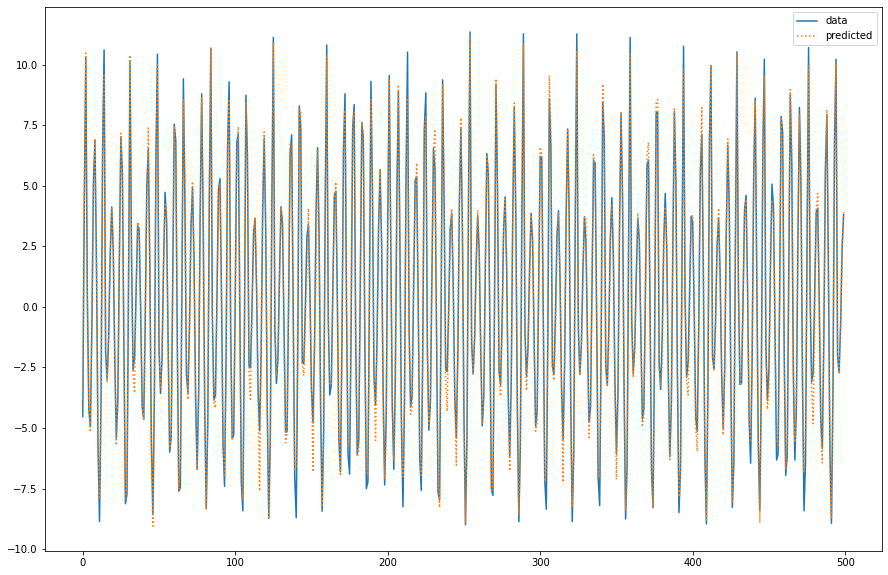

In [79]:
plt.plot(range(500),data.ts[train_size:train_size+500], label='data')
plt.plot(y_pred_out,':',label='predicted')
plt.legend();

In [77]:
y_pred_out.shape

(500,)